<a href="https://colab.research.google.com/github/eTcilopp/temp_python_intro_course_gb/blob/master/a_b_testing/Homework_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
dataset_path = "результаты А_B - cookie_cats 2.csv"
df = pd.read_csv(dataset_path)

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB



# Описание данных
gate_30 - это контрольная группа<br>
gate_40 - тестовая группа<br>
sum_gamearound - число игровых сессий в течение первых 14 дней после установки<br>
retention_1 - вернулся ли пользователь в игру через 1 день после установки<br>
retention_7 - вернулся ли пользователь в игру через 7 дней после установки<br>

In [6]:
gate_30_df = df[df['version']=='gate_30']
gate_40_df = df[df['version']=='gate_40']

In [8]:
df.shape

(90189, 5)

Насколько я понял, главной задачей анализа является ответ на ворос:
<br>
Меняется ли Retention rate (коэффициент удержания) в зависимости от того,<br>
на какой игровой гейт отправлен игрок.

In [39]:
df_retention = df[["retention_1","retention_7"]].mean()
print(f"1-day retention ratio: {round(df_retention[0],4)}% \
      \n7-days retention ratio: {round(df_retention[1],4)}%")

1-day retention ratio: 0.4452%       
7-days retention ratio: 0.1861%


Мы получили общие данные по обеим группам (тестовой и контрольной)
<br>
и можем посмотреть эти же метрик по группам

In [42]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean"})
df_retention_ab

,userid,retention_1,retention_7
version,,,
gate_30,44700,0.448188,0.190201
gate_40,45489,0.442283,0.182000


Видно, что Retention rate слегка больше у пользователей из gate30
<br>
Попробуем оценить статистическую значимость этого различия
<br>
Для налачала проверим данные на "нормальность"

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


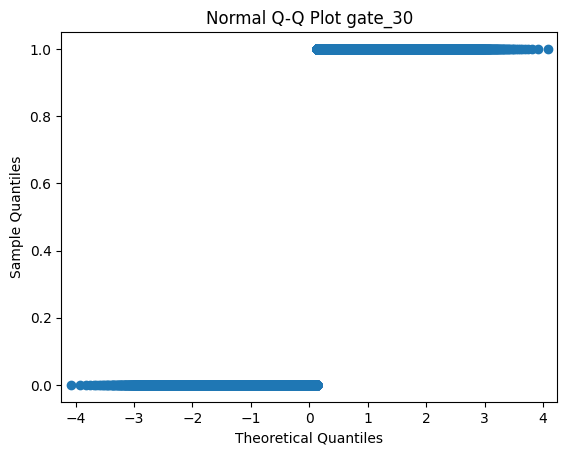

In [44]:
fig = sm.qqplot(gate_30_df['retention_1'].values, color='green')
plt.title('Normal Q-Q Plot retention_1 gate_30')
plt.show;

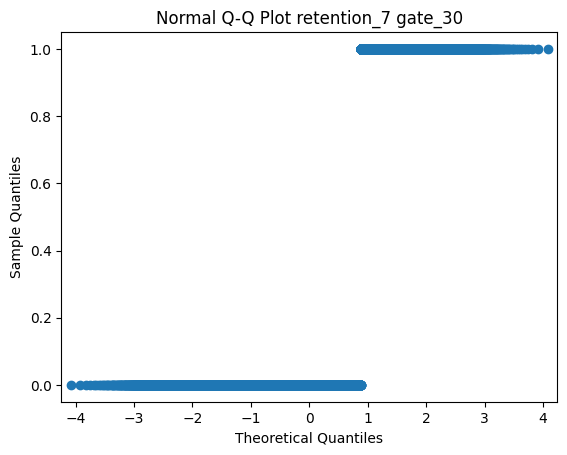

In [45]:
fig = sm.qqplot(gate_30_df['retention_7'].values, color='green')
plt.title('Normal Q-Q Plot retention_7 gate_30')
plt.show;

Данные совсем не похожи на нормальные.
<br>
Применим бутстраппинг для получения нормальной выборки

In [46]:
boot_1d = list()
boot_7d = list()
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)


boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

Получаем две выборки средних величин для retention_1 и retention_7
<br>
проверим их на нормальность

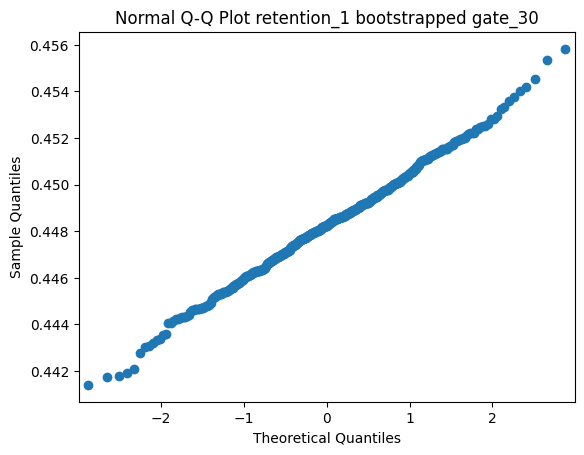

In [52]:
fig = sm.qqplot(boot_1d['gate_30'].values)
plt.title('Normal Q-Q Plot retention_1 bootstrapped gate_30')
plt.show;

Распределение похоже  на нормальное, что ожидаемо.
<br>
Применим тест  Шапиро-Уилка, чтобы быть уверенным

In [58]:
for arr in [boot_1d['gate_30'], boot_1d['gate_40'], boot_7d['gate_30'], boot_7d['gate_40']]:
  print(f'p_value: {stats.shapiro(arr.values)[1]}')

p_value: 0.7478017210960388
p_value: 0.6676298379898071
p_value: 0.7020915150642395
p_value: 0.5160696506500244


В каждой полученной выборке p_value > уровня статистической значимости,<br>следовательно распределение нормально.
<br>
Проверим, равны ли дисперсии

In [64]:
var_30 = np.var(boot_1d['gate_30'].values, ddof=1)
var_40 = np.var(boot_1d['gate_40'].values, ddof=1)
print(f'{var_30}\n{var_40}')

5.316166520225713e-06
4.913824057912675e-06


In [65]:
var_30 = np.var(boot_7d['gate_30'].values, ddof=1)
var_40 = np.var(boot_7d['gate_40'].values, ddof=1)
print(f'{var_30}\n{var_40}')

3.43123342215636e-06
3.24716474146289e-06


Дисперсии примерно равны - смело применяем t-тест Стьюдента для независимых выборок.

In [61]:
t_stat, p_value = stats.ttest_ind(boot_1d['gate_30'].values, boot_1d['gate_40'].values, equal_var=True)
print(p_value)

9.875505378793035e-217


Значение p_value значительно меньше уровня статистической значимости.
<br>
Следовательно, принимаем альтернативную гипотезу:
<br>
перенаправление игроков на gate_30 увеличивает retention 1
<br>
Проведем тот же тест для retention 7

In [66]:
t_stat, p_value = stats.ttest_ind(boot_7d['gate_30'].values, boot_7d['gate_40'].values, equal_var=True)
print(p_value)

0.0


Значение p_value и в этом случае значительно меньше уровня статистической значимости.
Следовательно, принимаем альтернативную гипотезу:
перенаправление игроков на gate_30 увеличивает retention 1
Проведем тот же тест для retention 7

# Выводы:
Проведенный А/В тест показал эффективность внедренных изменений для увеличения
<br>коэффициент удержания игроков. Следует внедрить изменение в PRODUCTION